## Load libraries

In [1]:
library(plyr)
library(dplyr)
library(ggplot2)
library(reshape)
library(reshape2)
library(tidyverse)
library(data.table)
library(Rtsne)
library(ggrepel)
library(repr)

theme_nogrid = function(...) theme_bw() + theme(axis.line = element_line(colour = "black"),
                            panel.grid.major = element_blank(),
                             panel.grid.minor = element_blank(),
                             panel.background = element_blank())


Attaching package: ‘dplyr’


The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘reshape’


The following object is masked from ‘package:dplyr’:

    rename


The following objects are masked from ‘package:plyr’:

    rename, round_any



Attaching package: ‘reshape2’


The following objects are masked from ‘package:reshape’:

    colsplit, melt, recast


── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ tibble  3.1.8     ✔ purrr   0.3.5
✔ tidyr   1.2.1     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ──────────────────────────────────────────────────────────────────────────────────────

## Set paths to reference files

In [2]:
cancers=c('ccRCC','CRC','CESC','HNSCC','UCEC','GBM','BRCA','OV','MM','PDAC')

#Tissue- and cancer cell-specific DEGs
degs=read.table('../data/snRNA/Table_S2b_tiss_cancer_DEGs.txt',sep='\t',header=T)
degs=degs[degs$p_val_adj<0.05 & degs$avg_log2FC>0,]

#Matrix with expression averaged per tumor cells from each sample, and per normal cells from tissue
tab_1=fread('../data/snRNA/Average_expression_matrix.SCT.DataSlot.20230213.tsv',sep='\t')

#Cell counts per each cell group in matrix with average RNA expression
meta=read.table('../data/snRNA/Cell_count_perGroup.forAverageExpressionMatrix.20230213.tsv',sep='\t',header=T)

#ATAC catalog
path_to_ATAC_catalog='../data/ATAC_catalog.20220114.v2.txt'

#Colors for cancer types
cols=readRDS('../data/Colors_panatac_v2.0.rds')
dis_cols_ed <- cols$Cancer

#Colors for tissue types
tiss_cols=c("Tumor"="#377EB8","Normal"="#4DAF4A","Met"="#E41A1C")

Warning message in fread("../data/snRNA/Average_expression_matrix.SCT.DataSlot.20230213.tsv", :
“Detected 233 column names but the data has 234 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


In [3]:
tab_1=as.data.frame(tab_1)
rownames(tab_1)=tab_1[,1]
tab_1=tab_1[,-1]
tab_1=t(tab_1)
rownames(tab_1)=gsub('SCT\\.','',rownames(tab_1))
rownames(tab_1)=gsub('\\.','-',rownames(tab_1))
rownames(tab_1)=gsub('PDAC__Acinar-REG-','PDAC__Acinar-REG+',rownames(tab_1))

In [4]:
row_annot=as.data.frame(rownames(tab_1))
colnames(row_annot)='ID'
row_annot$Cell_type=gsub('(.*)__(.*)','\\2',row_annot$ID)
row_annot$Cell_type=gsub('(.*)_(.*)_(.*)','\\3',row_annot$ID)
row_annot$Cell_type=gsub('-',' ',row_annot$Cell_type)

cell_types= unique(row_annot$Cell_type)


In [5]:
sel_cell_types=cell_types[!(cell_types %in% c('','Fibroblasts','Macrophages','T-cells','Endothelial',
'DC','B-cells','Unknown','Pericytes','Microglia','NK','Mast','Tregs','Alveolar',
'Hepatocytes','Cholangiocytes','Neurons','Skeletal Muscle','Erythrocytes','Neurons','Skeletal Muscle','Pre B cells','T cells','Neutrophils','Immune','B cells','Monocytes','Plasma','doublets','Other_doublets','Unknown'))]


In [6]:
row_annot=row_annot[row_annot$Cell_type %in% sel_cell_types,]
row_annot$Disease=gsub('(.*)__(.*)','\\1',row_annot$ID)
row_annot$Disease=gsub('(.*)_(.*)_(.*)','\\1',row_annot$ID)
row_annot$Disease=gsub('(.*)__(.*)','\\1',row_annot$Disease)

row_annot$Piece_ID=gsub('(.*)__(.*)__Tumor','\\2',row_annot$ID)
row_annot$Disease=ifelse(row_annot$Piece_ID %in% c("HT029B1-S1PC","HT035B1-S1PA","HT141B1-S1H1","HT206B1-S1H4","HT1408-06","HT268B1-Th1H3","HT271B1-S1H3","HT378B1-S1H1", "HT378B1-S1H2", "HT384B1-S1H1", "HT517B1-S1H1"),'BRCA_Basal',row_annot$Disease)


tab=tab_1[row_annot$ID,]

In [7]:
#Remove cell groups with too few number of cells
colnames(meta)=c('Cell_type','Cell_count')
meta$Cell_type=gsub(' ','-',meta$Cell_type)

meta_s=meta[meta$Cell_count>=20,]

In [8]:
#Add row annotation
row_annot_1=row_annot[row_annot$ID %in% meta_s$Cell_type & 
                      !(row_annot$ID %in% c('ccRCC__C3L-00079-N__Tumor','ccRCC__C3N-00242-N__Tumor',
                                            'GBM__GBML019G1-M1N1__Tumor')),]
tab_s=tab[row_annot_1$ID,]
rownames(row_annot_1)=row_annot_1$ID

tab_s=tab[rownames(row_annot_1),unique(degs$Gene)]

#Make correlation matrix based on expression of tissue- and cancer-specific DEGs, using all cell groups
mydata.cor = cor(t(scale(tab_s)), method = c("pearson"))

In [9]:
#Add row annotation
dd1=as.matrix(mydata.cor)
row_annot=as.data.frame(row.names(dd1))
colnames(row_annot)='ID'
row_annot$Cell_type=gsub('(.*)__(.*)','\\2',row_annot$ID)
row_annot$Cell_type=gsub('(.*)_(.*)_(.*)','\\3',row_annot$ID)
row_annot$Cell_type=gsub('-',' ',row_annot$Cell_type)

row_annot$Disease=gsub('(.*)__(.*)','\\1',row_annot$ID)
row_annot$Disease=gsub('(.*)_(.*)_(.*)','\\1',row_annot$ID)
row_annot$Disease=gsub('(.*)__(.*)','\\1',row_annot$Disease)

row_annot$Piece_ID=gsub('(.*)__(.*)__Tumor','\\2',row_annot$ID)
row_annot$Disease=ifelse(row_annot$Piece_ID %in% 
                         c("HT029B1-S1PC","HT035B1-S1PA","HT141B1-S1H1","HT206B1-S1H4",
                           "HT1408-06","HT268B1-Th1H3","HT271B1-S1H3","HT378B1-S1H1", "HT378B1-S1H2", 
                           "HT384B1-S1H1", "HT517B1-S1H1"),'BRCA_Basal',row_annot$Disease)
rownames(row_annot)=row_annot$ID

In [10]:
#Extract correlation coefficients between samples from each tumor type and their respective CNCs.
cancers=c('GBM','PDAC','UCEC','BRCA','BRCA_Basal','ccRCC','CRC','OV','HNSCC','CESC','SKCM')
all_stat=NULL
for(can in cancers){
print(can)

if(can %in% c('BRCA','BRCA_Basal')){
    row_annot_s=row_annot[row_annot$Disease %in% c('BRCA','BRCA_Basal'),]
    dd1_s=dd1[rownames(row_annot_s),rownames(row_annot_s)]
    row_annot_s1=row_annot_s[row_annot_s$Cell_type=='Tumor' & row_annot_s$Disease==can,]
    row_annot_s2=row_annot_s[row_annot_s$Cell_type!='Tumor',]
}else if (can %in% c('CESC','HNSCC')){
    row_annot_s=row_annot[row_annot$Disease %in% c('CESC','HNSCC'),]
    dd1_s=dd1[rownames(row_annot_s),rownames(row_annot_s)]
    row_annot_s1=row_annot_s[row_annot_s$Cell_type=='Tumor' & row_annot_s$Disease==can,]
    row_annot_s2=row_annot_s[row_annot_s$Cell_type!='Tumor',]

}else if (can %in% c('OV','UCEC')){
    row_annot_s=row_annot[row_annot$Disease %in% c('OV','UCEC'),]
    dd1_s=dd1[rownames(row_annot_s),rownames(row_annot_s)]
    row_annot_s1=row_annot_s[row_annot_s$Cell_type=='Tumor' & row_annot_s$Disease==can,]
    row_annot_s2=row_annot_s[row_annot_s$Cell_type!='Tumor',]

}else{
    row_annot_s=row_annot[row_annot$Disease==can,]
    dd1_s=dd1[rownames(row_annot_s),rownames(row_annot_s)]
    row_annot_s1=row_annot_s[row_annot_s$Cell_type=='Tumor',]
    row_annot_s2=row_annot_s[row_annot_s$Cell_type!='Tumor',]

}
    dd1_s1=dd1_s[rownames(row_annot_s1),rownames(row_annot_s2)]

cell_types=unique(row_annot_s2$Cell_type)
all_tab_h1=NULL
for (cell_t in cell_types){
    ids=rownames(row_annot_s2[row_annot_s2$Cell_type==cell_t,])
    tab_h=dd1_s1[,ids]
    tab_h1=as.data.frame(reshape2::melt(as.matrix(tab_h)))
    tab_h1$Cell_type=cell_t
    tab_h1$Cancer=can
    all_tab_h1=rbind(all_tab_h1,tab_h1)	
}
all_tab_h1=as.data.frame(all_tab_h1)
all_stat=rbind(all_stat,all_tab_h1)
}

all_stat=as.data.frame(all_stat)

[1] "GBM"
[1] "PDAC"
[1] "UCEC"
[1] "BRCA"
[1] "BRCA_Basal"
[1] "ccRCC"
[1] "CRC"
[1] "OV"
[1] "HNSCC"
[1] "CESC"
[1] "SKCM"


In [11]:
#Set the order of violins based on the max median of correlation coefficients
all_stat_s=all_stat
all_stat_s$Case=gsub('(.*)__(.*)__(.*)','\\2',all_stat_s$Var1)

st_acc=all_stat_s
st_acc=aggregate(st_acc$value, by=list(st_acc$Cell_type, st_acc$Cancer), FUN='median')
colnames(st_acc)=c('Cell_type','Cancer','Median_dist')
st_acc=st_acc[order(st_acc$Median_dist),]
st_acc$ID=paste(st_acc$Cancer,st_acc$Cell_type,sep='__')

In [12]:
#Add Sample_type info from the ATAC catalog
cat=read_delim(path_to_ATAC_catalog,show_col_types = FALSE)
cat=as.data.frame(cat)
colnames(cat)=gsub(' ','_',colnames(cat))

cat=cat %>% dplyr::select ('Piece_ID','Sample_Type')

colnames(all_stat_s)[6]='Piece_ID'
all_stat_s=merge(all_stat_s,cat)

In [13]:
all_stat_s$Cancer=factor(all_stat_s$Cancer,levels=c("BRCA","BRCA_Basal","PDAC","CRC","UCEC",
                                                    "OV","HNSCC","CESC","SKCM","ccRCC","GBM"))
all_stat_s$ID=paste(all_stat_s$Cancer,all_stat_s$Cell_type,sep='__')

all_stat_s=all_stat_s %>% mutate(ID=factor(ID, levels=c(st_acc$ID))) %>% arrange(ID)
all_stat_s$Cell_type=factor(all_stat_s$Cell_type,levels=unique(all_stat_s$Cell_type))

In [14]:
#Set x-axis labels
ids=unique(all_stat_s$ID)
ids=ids[!is.na(ids)]
x_ids=gsub('.*__(.*)','\\1',ids)
x_ids=gsub('TA','Transit Amplifying',x_ids)
x_ids=gsub('ADM','Acinar-to-Ductal metaplasia',x_ids)
x_ids=gsub('OPC','Oligodendrocyte Precursor',x_ids)
x_ids=gsub('Collecting Duct ','',x_ids)
x_ids=gsub('Endometrial ','',x_ids)
x_ids=gsub('Distal Stem Cells','Distal Stem',x_ids)
x_ids=gsub('Distal Enterocytes','Distal Enterocyte',x_ids)
x_ids=gsub('Distal Mature Enterocytes','Distal Mature Enterocyte',x_ids)
x_ids=gsub('Goblet Cells','Goblet',x_ids)
x_ids=gsub('Islets','Islet',x_ids)
x_ids=gsub('Secretory epithelial cells','Secretory Epithelial',x_ids)
x_ids=gsub('Ciliated epithelial cells','Ciliated Epithelial',x_ids)
x_ids=gsub('Luminal progenitor','Luminal Progenitor',x_ids)
x_ids=gsub('Luminal mature','Luminal Mature',x_ids)
x_ids=gsub('Basal progenitor','Basal Progenitor',x_ids)
x_ids=gsub('Principal Cells','Principal',x_ids)
x_ids=gsub('Podocytes','Podocyte',x_ids)
x_ids=gsub('Connecting tubule','Connecting Tubule',x_ids)
x_ids=gsub('Oligodendrocyte Precursors','Oligodendrocyte Precursor',x_ids)
x_ids=gsub('Astrocytes','Astrocyte',x_ids)
x_ids=gsub('Oligodendrocytes','Oligodendrocyte',x_ids)
x_ids=gsub('Normal epithelial cells','Normal Epithelial',x_ids)
x_ids=gsub('Normal squamous cells','Normal Squamous',x_ids)
x_ids=gsub('Keratinocytes','Keratinocyte',x_ids)
x_ids=gsub('Melanocytes','Melanocyte',x_ids)
names(x_ids)=ids

## Do plotting with ggplot2

In [15]:
p <- ggplot(data = all_stat_s, aes(x=ID, y=value))

p <- p + geom_violin(width=0.6,aes(color=Cancer))

p <- p + stat_summary(fun = median, fun.min = median, fun.max = median, geom = "crossbar", width=0.7)

p <- p + geom_jitter(position=position_jitter(0.2),size=1,aes(fill=Sample_Type,shape=Sample_Type))

p <- p + facet_grid(.~Cancer,drop=T,scales = "free", space = "free")+scale_x_discrete(labels=x_ids)

p <- p + theme_bw() + theme_nogrid() + labs(title="",x="Cancer",y="Correlation coef.")

p <- p + theme(axis.text.x = element_text(colour="black", size=10,  angle=45, vjust = 1,hjust=1), axis.text.y = element_text(colour="black", size=10),axis.ticks = element_blank())

p <- p + theme(legend.position = "bottom")+scale_shape_manual(values=c('Tumor'=22,'Met'=21))

p <- p + scale_color_manual(values=dis_cols_ed) + scale_fill_manual(values=tiss_cols) +theme(panel.spacing.x = unit(0, "lines"), panel.spacing.y = unit(0, "lines"))

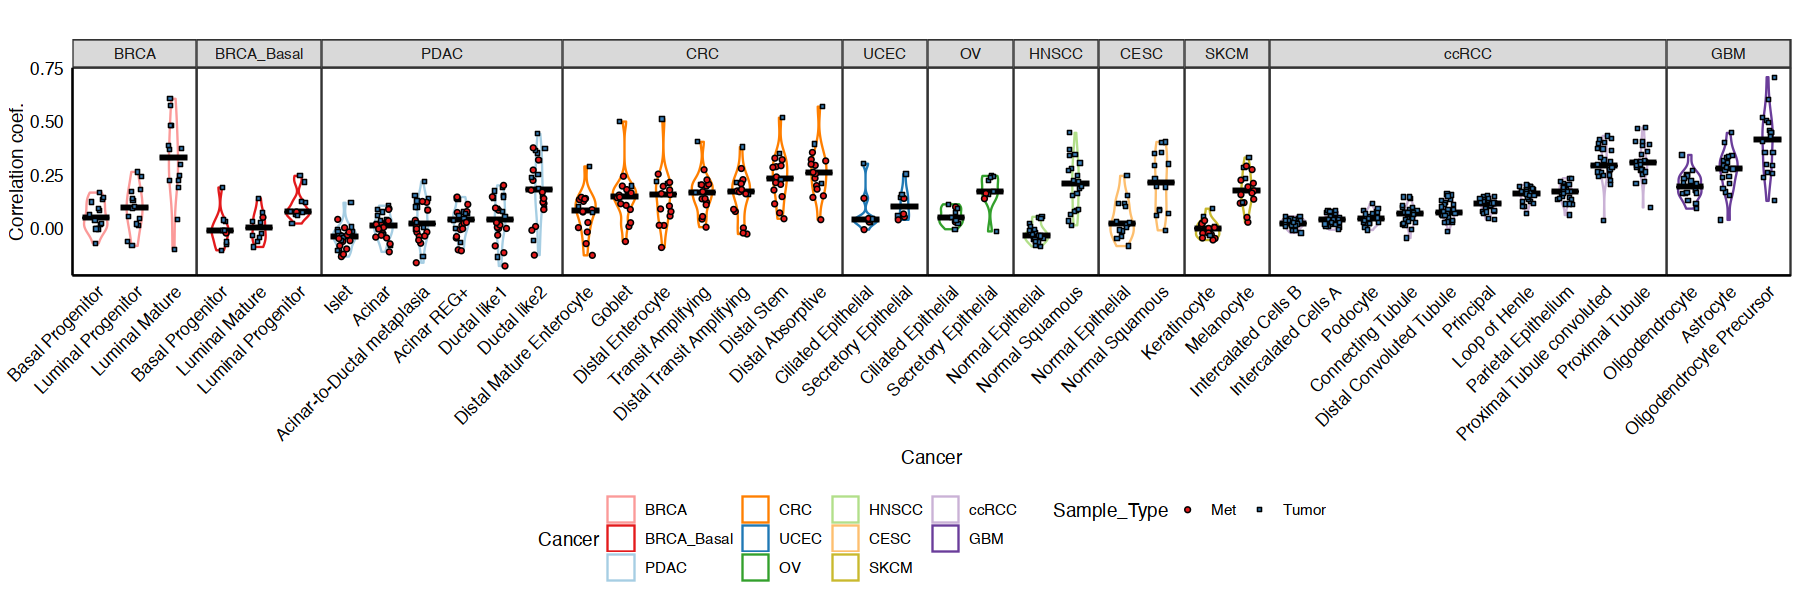

In [16]:
options(repr.plot.width=15, repr.plot.height=5)
p